# Latent Dirichlet allocation (LDA)

LDA (скорочення від Latent Dirichlet Allocation) — це модель машинного навчання без вчителя, яка приймає на вхід документи і визначає теми цих документів. Один документ може містити декілька тем і модель оцінює, який відсоток належності документа до кожної зі знайдених тем.
Кожна тема представлена у вигляді зваженого списку слів. Нижче наведено приклад теми:

```
lower * 0,2 | rose * 0,15 | plant * 0,09 |...
```

Існує 3 основних параметри моделі:
* **num_topics** - кількість тем
* **eta** - кількість [distribution of the]  слів, які описують тему
* **alpha** - кількість [distribution of the] тем на документ

# Python пакети

In [1]:
# to fix ModuleNotFoundError: No module named 'langdetect' in python venv
# https://stackoverflow.com/a/46367799/11411421
import sys
sys.path.append('../nlp_sandbox_venv/lib/python3.7/site-packages/')

In [2]:
import numpy as np
import pandas as pd
from gensim import corpora, models
from gensim.models import Phrases
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain # to flatten list of sentences of tokens into list of tokens
import pyLDAvis; pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as gensimvis
from langdetect import detect
from tqdm import tqdm_notebook; tqdm_notebook().pandas()
import seaborn as sns
%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/requests/__init__.py:114: RequestsDependencyWarning: urllib3 (1.24.3) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


0it [00:00, ?it/s]

In [3]:
from gensim import __version__ as gensim_version
from nltk import __version__ as nltk_version
from pyLDAvis import __version__ as ldavis_version
from importlib_metadata import version
from tqdm import __version__ as tqdm_version

print("gensim version:", gensim_version)
print("NLTK version:", nltk_version)
print("pyLDAvis version:", ldavis_version)
print("langdetect version:", version('langdetect'))
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("seaborn version:", sns.__version__)
print("tqdm version:", tqdm_version)

gensim version: 4.2.0
NLTK version: 3.6.1
pyLDAvis version: 3.3.1
langdetect version: 1.0.9
numpy version: 1.21.6
pandas version: 1.3.5
seaborn version: 0.11.2
tqdm version: 4.64.0


Для реалізації LDA в Python я використовую пакет [gensim](https://radimrehurek.com/gensim/auto_examples/index.html#documentation). Для лематизації, визначення частин мови та інших етапів підготовки тексту використовується пакет [NLTK](https://www.nltk.org/install.html). Для визначення мови використовується [langdetect](https://github.com/Mimino666/langdetect). Для візуалізації LDA моделі використовується пакет [pyLDAvis](https://pyldavis.readthedocs.io/en/latest/readme.html).

# Завантажити дані

У цьому прикладі використовується набір даних статей, взятих з веб-сайту BBC. [Джерело даних](https://github.com/FelixChop/MediumArticles/blob/master/articles_bbc_2018_01_30.csv).

In [6]:
df = pd.read_csv('../data/original/articles_bbc_2018_01_30.csv')
print(df.shape)
df.head(3)

(309, 2)


articles lang
0  Image copyright PA/EPA Image caption Oligarch ...   en
1  Husband admits killing French jogger\r\n\r\nTh...   en
2  Media playback is unsupported on your device M...   en

# Підготовка даних
## Пропущені значення

In [5]:
df = df.dropna().reset_index(drop=True)
print(df.shape)

(308, 2)


## Залишити лише англомовні статті

Корпус містить статті на різних мовах, разом з тим більшість статей англомовні. Модель LDA гарно працює з мономовними корпусами текстів. Залишимо лише англомовні статті.

In [6]:
## Detect the language of the text:
# df["lang"] = df["articles"].progress_map(detect)
df["lang"].value_counts()

en    256
fa      9
fr      8
id      5
uk      4
vi      4
ru      4
hi      4
ar      4
sw      3
tr      2
es      2
pt      2
de      1
Name: lang, dtype: int64

In [7]:
df = df.loc[df["lang"].isin(["en"])].reset_index(drop=True)
print(df.shape)

(256, 2)


## Токенізація

In [8]:
df['articles'].head(1).tolist()[0][:300] # Print the first 3 sentences of the 1st article

'Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list\r\n\r\nRussian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.\r\n\r\nThe list names 210 top Russian'

In [9]:
df["sentences"] = df["articles"].progress_map(sent_tokenize)
df['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

  0%|          | 0/256 [00:00<?, ?it/s]

['Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list\r\n\r\nRussian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.',
 'The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.',
 'However, the US stressed those named were not subject to new sanctions.']

In [10]:
mapping_function = lambda sentences: [word_tokenize(sentence) for sentence in sentences]
df["tokens_sentences"] = df["sentences"].progress_map(mapping_function)
print(df['tokens_sentences'].head(1).tolist()[0][:3])

  0%|          | 0/256 [00:00<?, ?it/s]

[['Image', 'copyright', 'PA/EPA', 'Image', 'caption', 'Oligarch', 'Roman', 'Abramovich', '(', 'l', ')', 'and', 'PM', 'Dmitry', 'Medvedev', 'are', 'on', 'the', 'list', 'Russian', 'President', 'Vladimir', 'Putin', 'says', 'a', 'list', 'of', 'officials', 'and', 'businessmen', 'close', 'to', 'the', 'Kremlin', 'published', 'by', 'the', 'US', 'has', 'in', 'effect', 'targeted', 'all', 'Russian', 'people', '.'], ['The', 'list', 'names', '210', 'top', 'Russians', 'as', 'part', 'of', 'a', 'sanctions', 'law', 'aimed', 'at', 'punishing', 'Moscow', 'for', 'meddling', 'in', 'the', 'US', 'election', '.'], ['However', ',', 'the', 'US', 'stressed', 'those', 'named', 'were', 'not', 'subject', 'to', 'new', 'sanctions', '.']]


## Визначення частин мови та лематизація

Слова можуть мати різне написання в однині та множині, чоловічий та жіночий рід, тощо. Зазвичай, ці форми не мають якогось особливого значення в контексті теми тексту, а приведення їх до однієї форми дозволить зменьшити розмір словника та зробить модель точніше. Для цього можна зробити лематизацію чи стемінг. Лематизація краще, оскільки  враховує до якої частини мови належить слово, завдяки цьому результат виходить більш зрозумілий. 

In [11]:
mapping_function = lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences]
df["POS_tokens"] = df["tokens_sentences"].progress_map(mapping_function)
print(df['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/256 [00:00<?, ?it/s]

[[('Image', 'NN'), ('copyright', 'NN'), ('PA/EPA', 'NNP'), ('Image', 'NNP'), ('caption', 'NN'), ('Oligarch', 'NNP'), ('Roman', 'NNP'), ('Abramovich', 'NNP'), ('(', '('), ('l', 'NN'), (')', ')'), ('and', 'CC'), ('PM', 'NNP'), ('Dmitry', 'NNP'), ('Medvedev', 'NNP'), ('are', 'VBP'), ('on', 'IN'), ('the', 'DT'), ('list', 'NN'), ('Russian', 'NNP'), ('President', 'NNP'), ('Vladimir', 'NNP'), ('Putin', 'NNP'), ('says', 'VBZ'), ('a', 'DT'), ('list', 'NN'), ('of', 'IN'), ('officials', 'NNS'), ('and', 'CC'), ('businessmen', 'NNS'), ('close', 'RB'), ('to', 'TO'), ('the', 'DT'), ('Kremlin', 'NNP'), ('published', 'VBN'), ('by', 'IN'), ('the', 'DT'), ('US', 'NNP'), ('has', 'VBZ'), ('in', 'IN'), ('effect', 'NN'), ('targeted', 'VBN'), ('all', 'DT'), ('Russian', 'JJ'), ('people', 'NNS'), ('.', '.')], [('The', 'DT'), ('list', 'NN'), ('names', 'RB'), ('210', 'CD'), ('top', 'JJ'), ('Russians', 'NNPS'), ('as', 'IN'), ('part', 'NN'), ('of', 'IN'), ('a', 'DT'), ('sanctions', 'NNS'), ('law', 'NN'), ('aimed', 

Ще один класичний етап підготовки — використання лише іменників та дієслів. Ми вже виконали POS tagging (POS: Part-Of-Speech) і визначили до яких частин мови належать слова. Давайте залишимо лише потрібні нам частини мови.

In [12]:
def is_nouns_or_verbs(token_and_pos):
    return token_and_pos[1].startswith('N') or token_and_pos[1].startswith('V')

def get_only_nouns_and_verbs(tokens):
    return [token for token in tokens if is_nouns_or_verbs(token)]

mapping_function = lambda tokens_sentences: [get_only_nouns_and_verbs(tokens) for tokens in tokens_sentences]
df["POS_tokens"] = df["POS_tokens"].progress_map(mapping_function)
print(df['POS_tokens'].head(1).tolist()[0][:3])

  0%|          | 0/256 [00:00<?, ?it/s]

[[('Image', 'NN'), ('copyright', 'NN'), ('PA/EPA', 'NNP'), ('Image', 'NNP'), ('caption', 'NN'), ('Oligarch', 'NNP'), ('Roman', 'NNP'), ('Abramovich', 'NNP'), ('l', 'NN'), ('PM', 'NNP'), ('Dmitry', 'NNP'), ('Medvedev', 'NNP'), ('are', 'VBP'), ('list', 'NN'), ('Russian', 'NNP'), ('President', 'NNP'), ('Vladimir', 'NNP'), ('Putin', 'NNP'), ('says', 'VBZ'), ('list', 'NN'), ('officials', 'NNS'), ('businessmen', 'NNS'), ('Kremlin', 'NNP'), ('published', 'VBN'), ('US', 'NNP'), ('has', 'VBZ'), ('effect', 'NN'), ('targeted', 'VBN'), ('people', 'NNS')], [('list', 'NN'), ('Russians', 'NNPS'), ('part', 'NN'), ('sanctions', 'NNS'), ('law', 'NN'), ('aimed', 'VBN'), ('punishing', 'VBG'), ('Moscow', 'NNP'), ('meddling', 'VBG'), ('US', 'NNP'), ('election', 'NN')], [('US', 'NNP'), ('stressed', 'VBD'), ('named', 'VBN'), ('were', 'VBD'), ('sanctions', 'NNS')]]


In [13]:
# Inspired from https://stackoverflow.com/a/15590384
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

lemmatizer = WordNetLemmatizer()
    
# Lemmatizing each word with its POS tag, in each sentence
df["tokens_sentences_lemmatized"] = df["POS_tokens"].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

df['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

  0%|          | 0/256 [00:00<?, ?it/s]

[['Image',
  'copyright',
  'PA/EPA',
  'Image',
  'caption',
  'Oligarch',
  'Roman',
  'Abramovich',
  'l',
  'PM',
  'Dmitry',
  'Medvedev',
  'be',
  'list',
  'Russian',
  'President',
  'Vladimir',
  'Putin',
  'say',
  'list',
  'official',
  'businessmen',
  'Kremlin',
  'publish',
  'US',
  'have',
  'effect',
  'target',
  'people'],
 ['list',
  'Russians',
  'part',
  'sanction',
  'law',
  'aim',
  'punish',
  'Moscow',
  'meddle',
  'US',
  'election'],
 ['US', 'stress', 'name', 'be', 'sanction']]

## Видалення цифр

Видалення цифр теж зробить ваш текст більш чистим і придатним для використання. Деякі цифри, наприклад роки (2006, 1981) можуть мати значення у ваших темах і їх варто залишити, агрегувати чи замінити якимось значенням.

In [14]:
# TODO

## Трансформація вкладених списків токенів у пласкі списки

In [21]:
df["tokens"] = df["tokens_sentences_lemmatized"].map(lambda sentences: list(chain.from_iterable(sentences)))

## Видалення стоп слів

Є слова, які з’являються в текстах на геть різні теми та не є характерними, важливими в контексті якоїсь конкретної теми. Один із способів впоратися з цим – додати ці слова до списку стоп-слів.

In [16]:
stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something', 
                   'us', 'people', 'year', 'time']
all_stopwords = stopwords.words('English') + stopwords_verbs + stopwords_other

mapping_function = lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                   and token.lower() not in all_stopwords and len(token)>1]
df["tokens"] = df["tokens"].map(mapping_function)
df['tokens'].head(1).tolist()[0][:3]

['oligarch', 'roman', 'abramovich']

## Створення N-грам

In [17]:
tokens = df['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

In [18]:
tokens[0][:30]

['oligarch',
 'roman_abramovich',
 'pm_dmitry',
 'medvedev_list',
 'russian_president',
 'vladimir_putin',
 'list_official',
 'businessmen',
 'kremlin',
 'publish',
 'effect',
 'target',
 'list_russians',
 'part',
 'sanction_law',
 'aim_punish',
 'moscow',
 'meddle_election',
 'stress_name',
 'sanction',
 'putin_list',
 'act',
 'complicate',
 'tie',
 'escalate',
 'situation',
 'putin',
 'russia',
 'think',
 'economy']

## Підготуємо корпус для LDA від gensim

In [19]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]

Варто відібрати слова, які зустрічаються принаймні в 3 (або більше) документах. Це хороший спосіб видалення рідкісних слів, які не є важливими в темах. Так само і відсіювання слів, які занадто часто зустрічаються в текстах і теж не є важливими в темах. Для цього функція [filter_extremes](https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.filter_extremes) приймає наступні аргументи:
* **no_below** (int, optional) – зберігати токени, які містяться принаймні в no_below документах.
* **no_above** (float, optional) – зберігати токени, які містяться не більше ніж у no_above документів (частка від загального розміру корпусу, а не абсолютне число).

Видалення стоп-слів, які надто часто зустрічаються в текстах, збереження лише іменників та дієслів, видалення шаблонів, ітераційне тестування різних методів очищення покращать змодельовані теми. Це займе певний час :)

# LDA
## Запуск LDA

Кількість тем (`num_topics`): поексперементуйте з кількістю тем, щоб зрозуміти, яка кількість має сенс. Потрібно поглянути на змодельовані теми, щоб зрозуміти, чи має модель сенс чи ні. Подібно до K-Means, LDA модель може мати сенс на математичному рівні, але це не означає, що вона має сенс з точки зору людини.

`alpha` та `eta`: Можна налаштувати альфа та ета, щоб налаштувати свої теми. Почніть з «авто», а якщо теми не є релевантними, спробуйте інші значення. Рекомендовано використовувати низькі значення Alpha та Eta, щоб мати невелику кількість тем у кожному документі та невелику кількість відповідних слів у кожній темі. eta впливає на кількість слів, які описують тему. alpha впливає на кількість тем на документ.

`passes`: Збільште кількість проходів через корпус під час навчання, щоб мати кращу модель. 3 або 4 - це добре число, але можна підняти вище.

In [20]:
np.random.seed(123456)
num_topics = 10
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=25, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

CPU times: user 5.68 s, sys: 19.8 ms, total: 5.7 s
Wall time: 5.72 s


# Швидке дослідження результатів LDA
## Поглянути на знайдені теми

In [472]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.012*"town" + 0.012*"find" + 0.011*"island" + 0.010*"life" + 0.009*"africa" + 0.009*"history" + 0.009*"deal" + 0.009*"group" + 0.009*"photograph" + 0.008*"world" + 0.008*"day" + 0.008*"end" + 0.008*"form" + 0.007*"family" + 0.007*"work" + 0.007*"subject" + 0.007*"feel" + 0.007*"lead" + 0.006*"leave" + 0.006*"museum"

1: 0.011*"work" + 0.008*"news" + 0.008*"story" + 0.008*"find" + 0.008*"images" + 0.007*"become" + 0.007*"data" + 0.007*"report" + 0.007*"president" + 0.007*"base" + 0.006*"way" + 0.006*"include" + 0.006*"write" + 0.006*"call" + 0.006*"think" + 0.006*"system" + 0.005*"week" + 0.005*"add" + 0.005*"give" + 0.005*"tell"

2: 0.011*"city" + 0.009*"prey" + 0.009*"case" + 0.008*"restaurant" + 0.008*"find" + 0.008*"university" + 0.008*"dish" + 0.007*"part" + 0.007*"move" + 0.006*"store" + 0.006*"village" + 0.006*"way" + 0.006*"police" + 0.006*"work" + 0.006*"call" + 0.006*"star" + 0.006*"include" + 0.006*"house" + 0.005*"attack" + 0.005*"head"

3: 0.021*"eu" + 0.016*"government

## Визначення тем документа

In [473]:
print(df.articles.loc[0][:500])

Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list

Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.

The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.

However, the US stressed those named were not subject to new sanctions.

Mr Putin said the list was an unfr


In [474]:
lda_model[corpus[0]]

[(7, 0.99830496)]

## Визначення тем незнайомого документа

In [475]:
document = '''Eric Tucker, a 35-year-old co-founder of a marketing company in Austin, Tex., had just about 40 Twitter followers. But his recent tweet about paid protesters being bused to demonstrations against President-elect Donald J. Trump fueled a nationwide conspiracy theory — one that Mr. Trump joined in promoting. 

Mr. Tucker's post was shared at least 16,000 times on Twitter and more than 350,000 times on Facebook. The problem is that Mr. Tucker got it wrong. There were no such buses packed with paid protesters.

But that didn't matter.

While some fake news is produced purposefully by teenagers in the Balkans or entrepreneurs in the United States seeking to make money from advertising, false information can also arise from misinformed social media posts by regular people that are seized on and spread through a hyperpartisan blogosphere.

Here, The New York Times deconstructs how Mr. Tucker’s now-deleted declaration on Twitter the night after the election turned into a fake-news phenomenon. It is an example of how, in an ever-connected world where speed often takes precedence over truth, an observation by a private citizen can quickly become a talking point, even as it is being proved false.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], 
             columns=['topic #', 'weight', 'words in topic'])

topic #  weight                                     words in topic
0        1    0.38  0.011*"work" + 0.008*"news" + 0.008*"story" + ...
1        2    0.17  0.011*"city" + 0.009*"prey" + 0.009*"case" + 0...
2        9    0.45  0.019*"think" + 0.017*"work" + 0.016*"drug" + ...

# Розширене дослідження результатів LDA
## Розмітка тем всіх наявних документів

In [476]:
topics = [lda_model[corpus[i]] for i in range(len(df))]

In [477]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

0    1    2    3    4    5    6    7    8         9    10   11   12   13  \
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.038537  NaN  NaN  NaN  NaN   

    14        15   16   17        18   19  
0  NaN  0.091301  NaN  NaN  0.869287  NaN

In [478]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [479]:
document_topic.head()

0         1         2    3    4         5         6         7    8    9
0  0.0  0.000000  0.000000  0.0  0.0  0.000000  0.000000  0.998305  0.0  0.0
1  0.0  0.000000  0.000000  0.0  0.0  0.978048  0.000000  0.000000  0.0  0.0
2  0.0  0.927315  0.000000  0.0  0.0  0.000000  0.071777  0.000000  0.0  0.0
3  0.0  0.000000  0.000000  0.0  0.0  0.258813  0.000000  0.729918  0.0  0.0
4  0.0  0.000000  0.874711  0.0  0.0  0.124513  0.000000  0.000000  0.0  0.0

In [480]:
# Which document are about topic 7
document_topic.sort_values(7, ascending=False)[7].head(20)

86     0.999597
167    0.998990
0      0.998305
145    0.997912
15     0.997755
21     0.997196
100    0.994736
195    0.991891
227    0.991088
41     0.990109
29     0.990108
42     0.988888
163    0.988888
111    0.988888
120    0.985245
201    0.985245
45     0.978048
25     0.978047
24     0.970967
117    0.970967
Name: 7, dtype: float64

In [481]:
print(df.articles.loc[86][:1000])

Image caption Hi-de-Hi! was set in a holiday camp at the end of the 1950s

The antics of the employees of Maplins holiday camp entertained viewers for nearly a decade and made huge stars of the cast of Hi-de-Hi! Thirty years after the last episode was shown, on 30 January 1988, they have been sharing their memories with the BBC.

"All these years later, people say to me how wonderful it was and how we love the show," says Jeffrey Holland, who played the camp's comedian Spike Dixon.

"You can't get 19 or 20 million viewers now.

"I meet young actors now who know me from the 1980s, and they are often thrilled to meet me for that reason, and that's so gratifying."

Hi-de-Hi! was Holland's big break, with the role of Spike written with him in mind.

"It was the first thing I ever did that made my face known," the actor says.

"Whatever else I've done since, or will in the future, I'll always be that bloke from Hi-de-Hi! and I wouldn't want it any other way."

Image caption 


In [482]:
print(df.articles.loc[167][:1000])

Image copyright EPA Image caption Vladimir Putin seems certain to win in March after an opposition leader was barred from standing

An expected US report that could sanction Kremlin-linked oligarchs is an attempt to influence Russia's March presidential election, Moscow has said.

The US treasury report is expected to detail the closeness of senior Russian political figures and oligarchs to President Vladimir Putin, who is standing for re-election.

US officials accuse Russia of meddling in the 2016 US presidential elections.

Kremlin representatives have repeatedly denied the allegations.

Mr Putin's spokesman said the forthcoming report would be analysed.

Media playback is unsupported on your device Media caption All you need to know about the Trump-Russia investigation

Last year, US President Donald Trump enacted new sanctions on Russia but he accused Congress of overreaching itself and preventing him from easing penalties on Russia in the future.

The US president


In [483]:
# print(df.articles.loc[70][:1000])

In [484]:
# print(df.articles.loc[249][:1000])

In [485]:
print(df.articles.loc[0][:1000])

Image copyright PA/EPA Image caption Oligarch Roman Abramovich (l) and PM Dmitry Medvedev are on the list

Russian President Vladimir Putin says a list of officials and businessmen close to the Kremlin published by the US has in effect targeted all Russian people.

The list names 210 top Russians as part of a sanctions law aimed at punishing Moscow for meddling in the US election.

However, the US stressed those named were not subject to new sanctions.

Mr Putin said the list was an unfriendly act that complicated US-Russia ties but he said he did not want to escalate the situation.

Mr Putin said Russia should instead be thinking about "ourselves and the economy".

The list was also derided by a number of senior Russian officials who said it bore a strong resemblance to the Forbes magazine ranking of Russian billionaires. A US Treasury Department later told Buzzfeed that an unclassified annex of the report had been derived from the magazine.

Why did the US publish the l


## Погляньмо на розподіл тем у документах

Наведена нижче візуалізація полягає в тому, щоб показати всі документи відповідно до їх основної теми в діагональному форматі.

<AxesSubplot:>

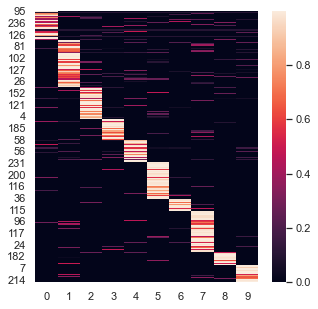

In [504]:
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

Візуалізація частки тем у документах (Документи – це рядки, теми – стовпці)

<AxesSubplot:>

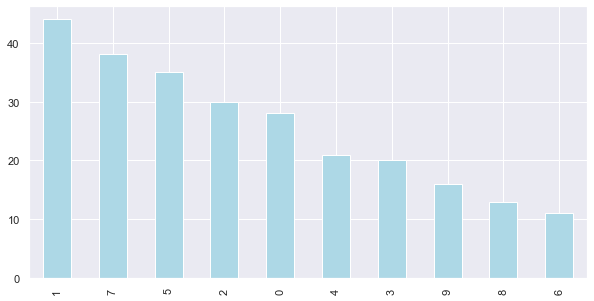

In [487]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

## Візуалізація тем

Існує чудовий спосіб уявити модель LDA, яку ви створили за допомогою пакета pyLDAvis. Ця візуалізація дозволяє порівнювати теми на зменшеному двовимірному просторі і спостерігати за розподілом слів у темах.

In [488]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
vis = gensimvis.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from im

# Підсумки

## Оцінювання результатів

* Чи можна інтерпретувати ваші теми?
* Ваші теми унікальні? (Дві різні теми мають різні слова)
* Ваші теми вичерпні? (чи всі ваші документи добре представлені цими темами?)

Якщо ваша модель відповідає цим 3 критеріям, це виглядає як хороша модель.

## Основні переваги LDA
 
### Швидкість
 
Зазвичай модель швидко працює. Звичайно, це залежить від ваших даних. Кілька факторів можуть уповільнити модель:
* Довгі документи
* Велика кількість документів
* Великий словниковий запас (особливо якщо ви використовуєте n-грами з великим значенням n)

### Інтерпретація
 
Ніяких ембедінгів, в результаті ви отримаєте лише список слів із вагами.

### Може визначити теми для незнайомих документів
 
Модель готова визначити теми для будь-якого документа. Звичайно, якщо ваш навчальний набір даних англійською мовою, і ви хочете передбачити теми китайського документа, це не спрацює. Але якщо нові документи мають таку саму структуру і повинні мати більш-менш однакові теми, це спрацює.

## Основні недоліки LDA

* Багато тонких налаштувань, що потребує розуміння як працює модель.
* Потребує людської інтерпретації, щоб представити результати моделі людям, які не є експертами.
* Ви не можете впливати на теми. Знання, що деякі з ваших документів розповідають про знайому вам тему, і не знайти її в темах, знайдених LDA, безумовно, буде засмучувати. І немає можливості сказати моделі, що деякі слова повязані. Ви повинні експерементувати, поки LDA дасть вам те, що ви хочете.

# Список джерел

* [An Overview of Topics Extraction in Python with Latent Dirichlet Allocation](https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html) та дзеркало на [towardsdatascience.com](https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc)
* [Félix Revert's LDA-BBC.ipynb](https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb)
* [Джерело даних](https://github.com/FelixChop/MediumArticles/blob/master/articles_bbc_2018_01_30.csv)
* [Topic Modeling with LSA, PLSA, LDA & lda2Vec](https://www.kdnuggets.com/2018/08/topic-modeling-lsa-plsa-lda-lda2vec.html)
* [Understanding NLP and Topic Modeling Part 1](https://www.kdnuggets.com/2019/11/understanding-nlp-topic-modeling-part-1.html)
* [Benchmarking Language Detection for NLP](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c)
* [StackOverflow: wordnet lemmatization and pos tagging in python](https://stackoverflow.com/a/15590384/11411421)